In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv
/kaggle/input/icr-identify-age-related-conditions/greeks.csv
/kaggle/input/icr-identify-age-related-conditions/train.csv
/kaggle/input/icr-identify-age-related-conditions/test.csv


# Exploratory Analysis

This section contains the code to satisfy https://github.com/Quantyra/kaggle-ml-pipeline-icr-challenge/issues/5
It processes and cleans the features, prepares them for use in the model.

See https://www.kaggle.com/competitions/icr-identify-age-related-conditions/data for information about the dataset

In [2]:
# Extracts the class column from the dataset and returns it. Then mutates the dataset by dropping the class column. Also ensures that Id column is completely unique and sets it as the index
def extract_classes(dataset):
    assert dataset['Id'].nunique() == dataset.shape[0]
    dataset.index = dataset['Id']
    dataset.drop(['Id'], axis='columns', inplace=True)
    if 'Class' in dataset.columns:
        y = dataset['Class']
        dataset.drop(['Class'], axis='columns', inplace=True)
        return y

In [3]:
# Some checks to ensure sanity of outputs after engineering
def data_integrity_checks(dataset, classes, initial_row_count):
    assert classes.name == 'Class'
    assert classes.shape[0] == dataset.shape[0]
    assert not dataset.isna().any().any() #No more nulls should be remaining as we converted them to zero
    assert dataset.shape[0] == initial_row_count

In [4]:
#Encode the categorical values, but put an error check in place for the test set since it doesn't have the second class in the sample data.
def encode_categories(dataset, column):
    if dataset[column].nunique() > 1:
        dataset[column] = pd.get_dummies(dataset[column], drop_first=True)
    else:
        dataset[column] = 0

In [5]:
#Mark rows that have null values with a binary flag, and reset null values to zeroes.
def mark_missing_observations(dataset):
    for column in dataset.columns:
        new_columns = dataset[column].apply(lambda x: 1 if pd.isna(x) else 0)
        new_columns.name = f"{column}_missing"
        dataset = pd.concat([dataset, new_columns], axis='columns')
        dataset[column] = dataset[column].fillna(0)
        
    return dataset

## Training set engineering

We clean the training set by extracting the classes column, encoding the EJ column as a binary categorical value, and marking those rows/columns that have missing data while replacing null values with zero. Then we do some data integrity checks to ensure we have no null values and sane outputs.

In [6]:
train_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
greeks_df = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
initial_row_count = train_df.shape[0]
y_train = extract_classes(train_df)
encode_categories(train_df, 'EJ')
train_df = mark_missing_observations(train_df)
train_df = train_df.astype(float)
data_integrity_checks(train_df, y_train, initial_row_count)
print('Summary Tables')
print('-----------')
print(train_df.info())
print('-----------')
print(train_df.describe())

Summary Tables
-----------
<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 000ff2bfdfe9 to ffcca4ded3bb
Columns: 112 entries, AB to GL_missing
dtypes: float64(112)
memory usage: 544.7+ KB
None
-----------
               AB            AF           AH          AM          AR  \
count  617.000000    617.000000   617.000000  617.000000  617.000000   
mean     0.477149   3502.013221   118.624513   38.968552   10.128242   
std      0.468388   2300.322717   127.838950   69.728226   10.518877   
min      0.081187    192.593280    85.200147    3.177522    8.138688   
25%      0.252107   2197.345480    85.200147   12.270314    8.138688   
50%      0.354659   3120.318960    85.200147   20.533110    8.138688   
75%      0.559763   4361.637390   113.739540   39.139886    8.138688   
max      6.161666  28688.187660  1910.123198  630.518230  178.943634   

               AX          AY          AZ           BC           BD   ...  \
count  617.000000  617.000000  617.000000   617.000000    6

## Correlation Matrix

The following heatmap shows cases of colinearity

In [7]:
corr = train_df.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3931: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.10/site-packages/pandas/io/formats/style.py:3932: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


## Shap

Shap can determine if any of the features provide value for linear models.

In [8]:
y_train

Id
000ff2bfdfe9    1
007255e47698    0
013f2bd269f5    0
043ac50845d5    0
044fb8a146ec    1
               ..
fd3dafe738fd    0
fd895603f071    0
fd8ef6377f76    0
fe1942975e40    0
ffcca4ded3bb    0
Name: Class, Length: 617, dtype: int64

In [9]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing


X_train, X_test, y_trainer, y_test = train_test_split(train_df, y_train, random_state=1)
scaler = preprocessing.StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
model = LogisticRegression(penalty=None, max_iter=1000, random_state=1)
model.fit(X_scaled, y_trainer)

masker = shap.maskers.Independent(data=X_test)

explainer = shap.Explainer(
    model, masker=masker, feature_names=X_train.columns, algorithm="linear"
)

sv = explainer(X_test)

/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/opt/conda/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100, num_

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


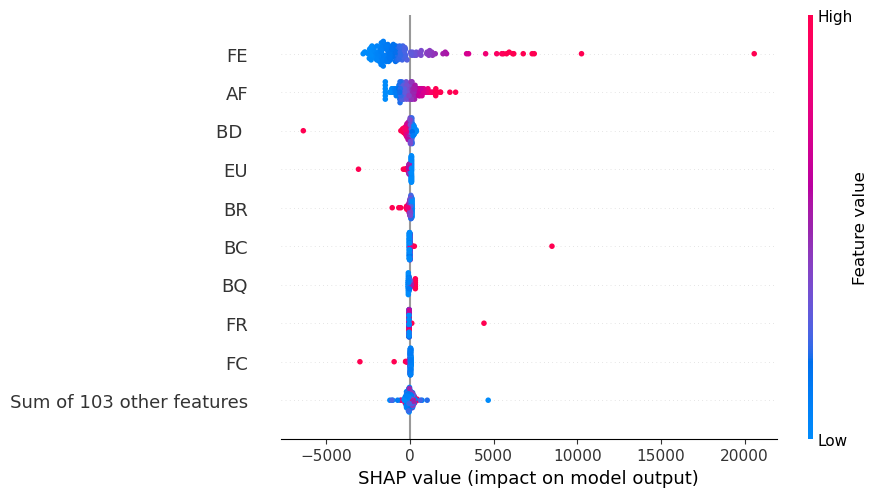

In [10]:
shap.plots.beeswarm(sv)

In [11]:
shap.initjs()
shap.plots.force(sv[0])